# Exemple 6 : studying the impact of using different rainfall estimation products - Senegal millet 2013-2023

The purpose of this notebook is to make two sets of simulations using two different satellite rainfall estimation products, in order to check at their impact on the simulation results, all parameters being equal otherwise.

## Imports

In [1]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import xarray as xr
from sarra_py import *
import geopandas as gpd
from joblib import Parallel, delayed
from contextlib import redirect_stdout, redirect_stderr

## 2. Preparing climate and rainfall data

For this example, we provide rainfall and climate data for Senegal in 2013-2023, sourced from TAMSAT v3.1 for rainfall, and AgERA5 for climate ; the following cell will download it and unzip it. 

- climate data includes daily min, max, mean temperatures (°C), solar irradiance (W/m2), and reference evapotranspiration (mm), sourced from AgERA5
- rainfall data includes... rainfall data (mm), sourced from TAMSAT v3.1 and CHIRPS v2.0



In [ ]:
import os
import urllib.request
import zipfile

# create a folder to store the data
os.makedirs('../data/exemple_data/exemple_6/', exist_ok=True)

# download AgERA5 and TAMSAT tiles
# download preformatted data from Zenodo repository
url = 'https://zenodo.org/records/14621757/files/exemple_data_Senegal_2013_2023.zip?download=1'
local_filename = '../data/exemple_data/exemple_6/exemple_data_Senegal_2013_2023.zip' # store the downloaded file in the ../data/exemple_data/ folder
urllib.request.urlretrieve(url, local_filename)
print("File 1 downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_6/exemple_data_Senegal_2013_2023.zip"
directory_to_extract_to = "../data/exemple_data/exemple_6/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File 1 unzipped.")

# download CHIRPS files
url = "https://zenodo.org/records/14641191/files/Senegal_CHIRPSv2.0_2013_2023.zip?download=1"
local_filename = "../data/exemple_data/exemple_6/Senegal_CHIRPSv2.0_2013_2023.zip"
urllib.request.urlretrieve(url, local_filename)
print("File 2 downloaded using urllib.")

# unzip data
path_to_zip_file = "../data/exemple_data/exemple_6/Senegal_CHIRPSv2.0_2013_2023.zip"
directory_to_extract_to = "../data/exemple_data/exemple_6/" # unzips the file in the same folder

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
print("File 2 unzipped.")



In [8]:
# we set the paths to the data
rainfall_TAMSAT_data_path = "../data/exemple_data/exemple_6/TAMSAT_v3.1_senegal_rfe_filled/"
rainfall_CHIRPS_data_path = "../data/exemple_data/exemple_6/CHIRPS_v2.0_Africa_senegal/"
climate_data_path = "../data/exemple_data/exemple_6/AgERA5_senegal/"

## 3. Defining yearly/dataset simulation function

Here we define a wrapper function that will perform for a given year and rainfall dataset all the operations for data loading and launching one simulation.

In [15]:
def perform_sim(year, rainfall_dataset):

    print("== performing simulation for year {} using rainfall dataset {} ==".format(year, rainfall_dataset))

    # setting the path to the rainfall data, depending on the passed dataset argument
    if rainfall_dataset == "TAMSAT":
        rainfall_data_path = rainfall_TAMSAT_data_path
    elif rainfall_dataset == "CHIRPS":
        rainfall_data_path = rainfall_CHIRPS_data_path

    # hiding all the outputs of this code section
    with open(os.devnull, 'w') as devnull, redirect_stdout(devnull), redirect_stderr(devnull):

        # defining the simulation period (interval in which data is loaded)
        # remember that we want to load data at least one month before the sowing date so that water balance can initialize properly
        date_start = datetime.date(year,4,1) # 01/04/year
        duration = 220

        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration) # get grid size 
        base_data = xr.Dataset() # initialize empty xarray dataset
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration) # load rainfall data
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration) # load climate data
        base_data = load_iSDA_soil_data(base_data, grid_width, grid_height) # load soil parameters
        base_data = calc_day_length_raster_fast(base_data, date_start, duration) # compute day length raster

        # load variety, cropping system and soil parameters
        file_paramVariete = "millet_variety.yaml"
        file_paramITK = "millet_niger_2017.yaml"
        file_paramTypeSol = "USA_iowa_V42.yaml"
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)
        paramITK["DateSemis"] = datetime.date(year,5,1) # setting the sowing date to 01/05/year

        data = base_data.copy() # creating simulation dataset by copying the base_data
        del base_data # deleting the base_data to free up memory

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

        data = run_model(paramVariete, paramITK, paramTypeSol, data, duration) # running the model

        return data["rdt"][-1,:,:] # returning the final yield

## 4. Run simulations

We will run simulations along 10 years to have some interannual variability.

In [ ]:
# loop over the years 2013 to 2023 included
years = range(2013, 2023 + 1)

n_jobs = 4 # number of parallel jobs, increase if you have lots of ram
results_CHIRPS = Parallel(n_jobs)(delayed(perform_sim)(year, "CHIRPS") for year in years)
results_TAMSAT = Parallel(n_jobs)(delayed(perform_sim)(year, "TAMSAT") for year in years)

## 5. Plot results

We will first make a box and whiskers plot representing the interannual simulated yield per department and per rainfall dataset.

We first have to compute the mean yield per deparment, hence the following ugly loop logic :

In [41]:
# load the shapefile of departements
gdf = gpd.read_file("https://geoportal.un.org/arcgis/sharing/rest/content/items/f8bcb307f3ad4f21a43ac8e2c68fa26c/data")

# create a dataframe to store the results
gdf_final = pd.DataFrame()

# loop over the years and the shapefile rows
for year in years : 
    gdf_inter = gdf.copy() # create a copy of the shapefile on which we will add the yield values
    gdf_inter["year"] = year # add the current year column
    for i in range(len(gdf_inter)): # loop over the shapefile rows (departements)
        # calculate the mean yield value for the current departement and store it in the intermediate dataset
        gdf_inter.loc[i, "yield_CHIRPS"] = results_CHIRPS[year-2013].rio.clip([gdf.iloc[i].geometry], gdf.crs, drop=False).mean().values
        gdf_inter.loc[i, "yield_TAMSAT"] = results_TAMSAT[year-2013].rio.clip([gdf.iloc[i].geometry], gdf.crs, drop=False).mean().values

    # concatenate the intermediate dataset to the final dataset
    gdf_final = pd.concat([gdf_final, gdf_inter])

# pivot table so that we have only one yield column for yield value, and another one indicating if we're working with CHIRPS or TAMSAT
gdf_final_melted = gdf_final[["adm1nm", "geometry", "year", "yield_TAMSAT", "yield_CHIRPS"]].melt(id_vars=["adm1nm", "geometry", "year"], var_name="dataset", value_name="yield")

Now we can plot our nice box and whiskers graph

In [67]:
import plotly.express as px

fig = px.box(gdf_final_melted, x="adm1nm", y="yield", color="dataset", title="Simulated yield distribution per department and satellite rainfall dataset, 2013-2023 period")
fig.show()


It seems that CHIRPS data lead quite often to simulated yields that are lower than with TAMSAT - though this does not seem to be statistically significant for all departments, and is not true for some of them.

We can also make some yearly maps displaying side by side the simulated yields :

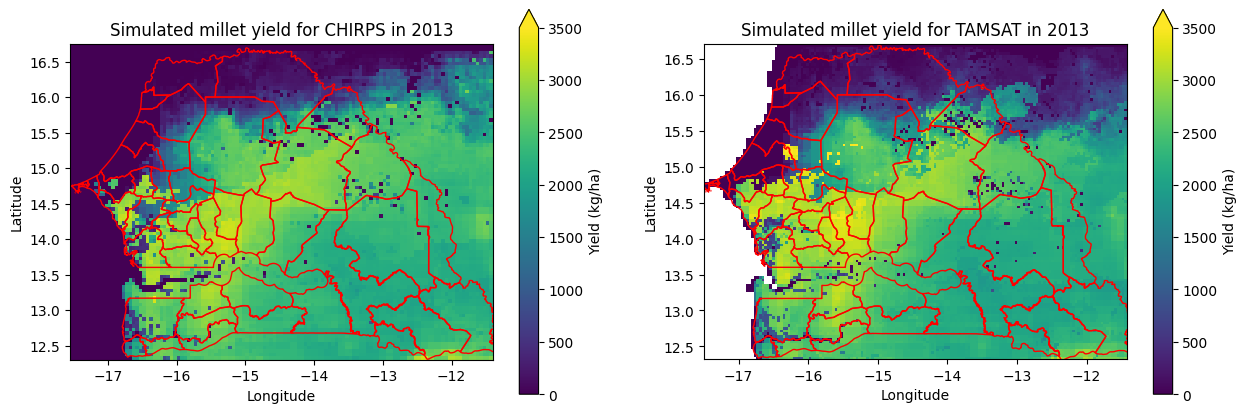

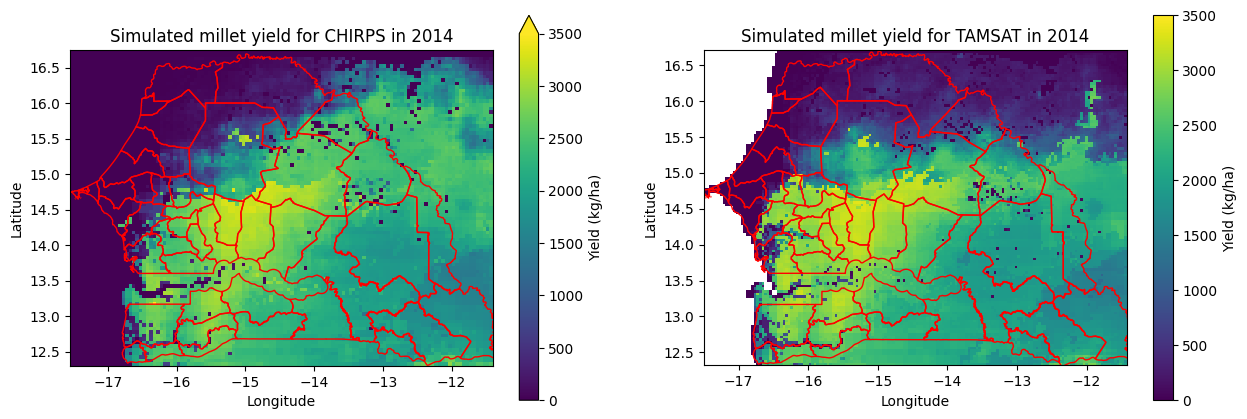

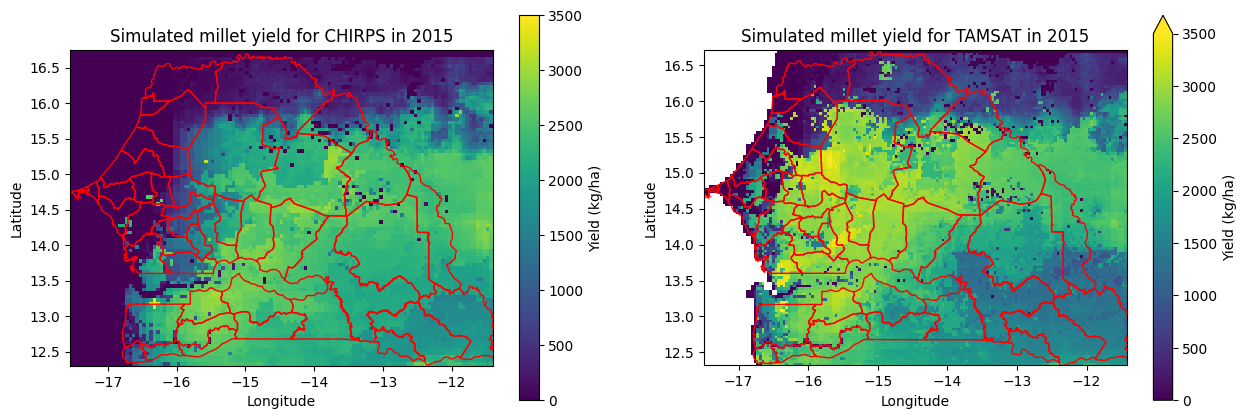

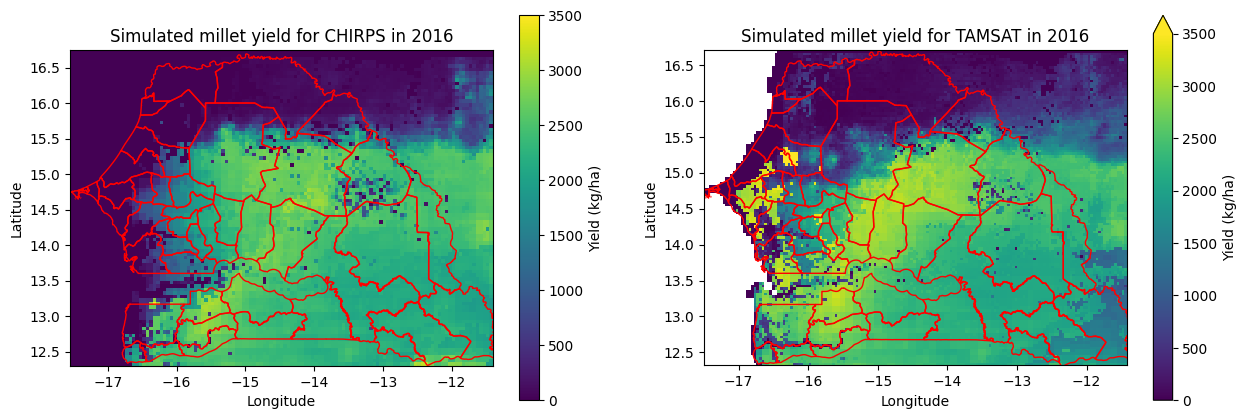

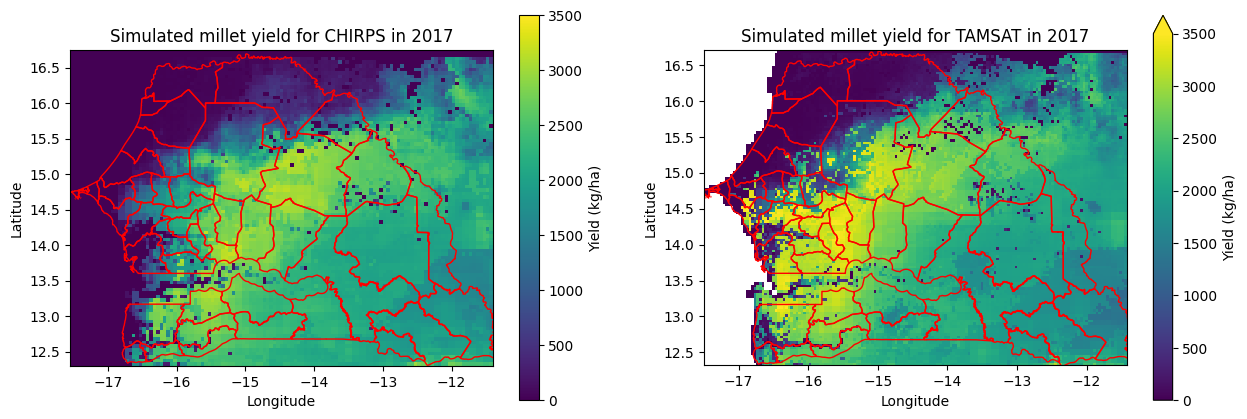

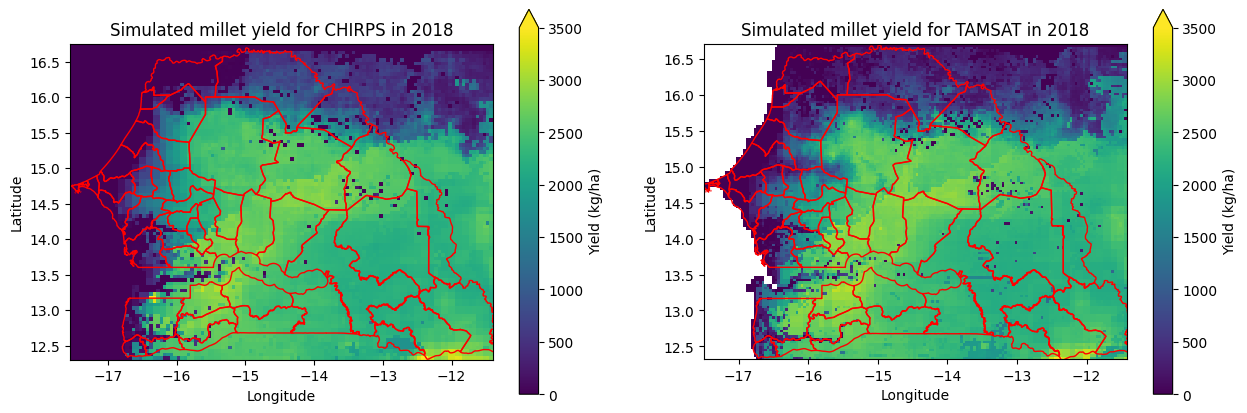

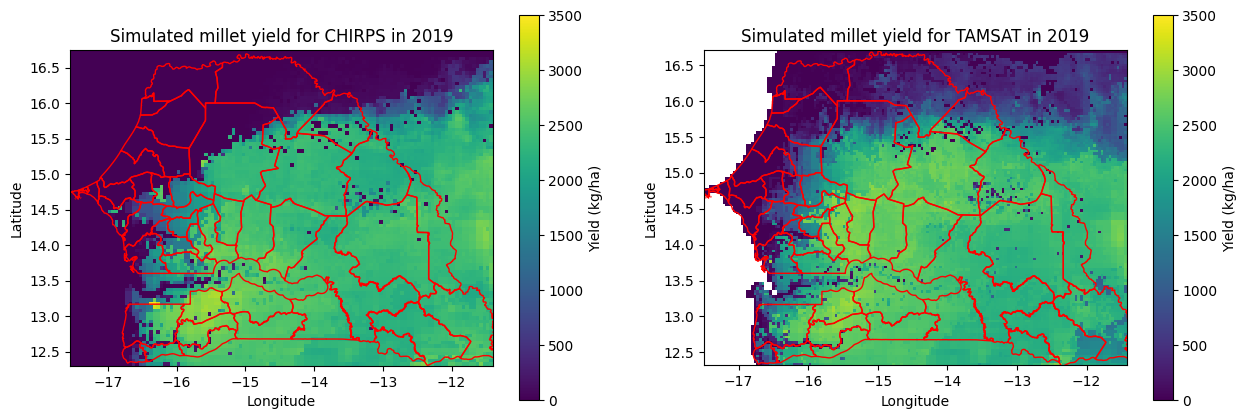

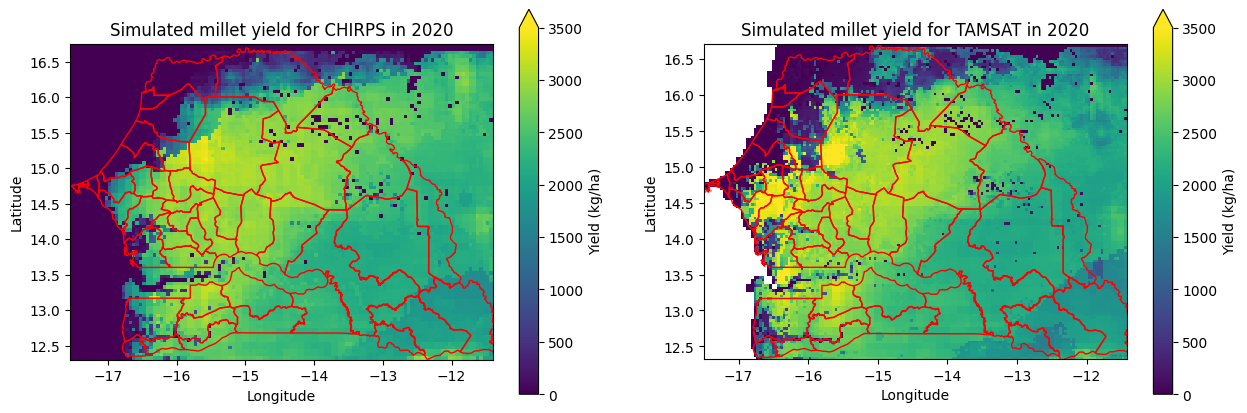

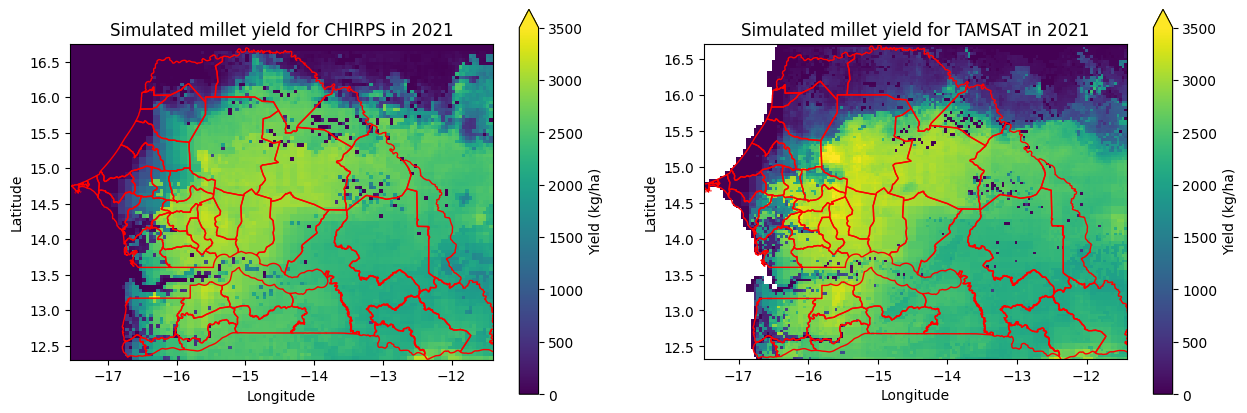

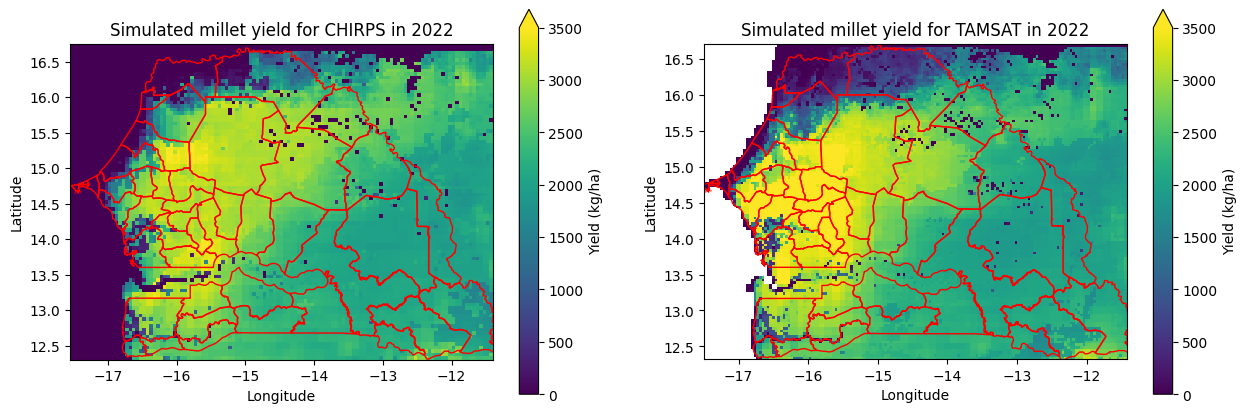

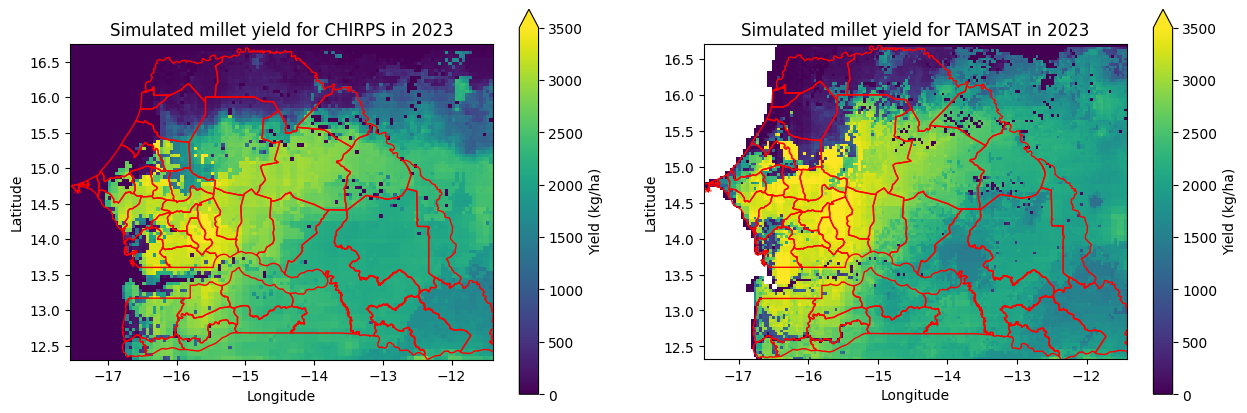

In [ ]:
# loop over the years to plot the results
for year in years :

    # plot CHIRPS
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    results_CHIRPS[year-2013].plot(cbar_kwargs={"label": "Yield (kg/ha)"}, vmin=0, vmax=3500)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Simulated millet yield for CHIRPS in {}".format(year))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # plot TAMSAT
    plt.subplot(1, 2, 2)
    results_TAMSAT[year-2013].plot(cbar_kwargs={"label": "Yield (kg/ha)"}, vmin=0, vmax=3500)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Simulated millet yield for TAMSAT in {}".format(year))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


Finally, we can compare 10-year mean simulated yield.

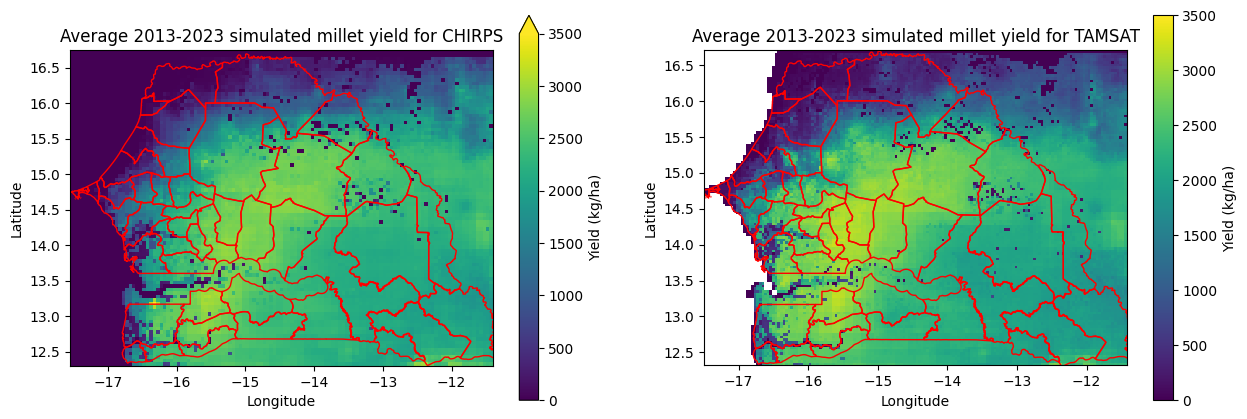

In [74]:
# plot CHIRPS
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
xr.concat(results_CHIRPS, dim="year").mean(dim="year").plot(cbar_kwargs={"label": "Yield (kg/ha)"}, vmin=0, vmax=3500)
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("Average 2013-2023 simulated millet yield for CHIRPS")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# plot TAMSAT
plt.subplot(1, 2, 2)
xr.concat(results_TAMSAT, dim="year").mean(dim="year").plot(cbar_kwargs={"label": "Yield (kg/ha)"}, vmin=0, vmax=3500)
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("Average 2013-2023 simulated millet yield for TAMSAT")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()
